### 時系列 理論

定常性  


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 



### 時系列 入門

In [12]:
df = pd.read_csv(r'./data_practice/日経平均.csv',encoding='utf-8', engine='python')
df['日付'] = df['日付'].astype('datetime64')
df.head(5)

,日付,終値
0,2015-01-05,17409
1,2015-01-06,16883
2,2015-01-07,16885
3,2015-01-08,17167
4,2015-01-09,17198


#### step1 データを観察します。自分の何らかの値が正規分布に従うかどうかを見ます。

下記は1個前の値と相関するかどうかを見るコードです。  
シャピロ検定で正規分布に従うかどうかを見れます。  
ここでは、シャピロ検定の結果は、0.00047217801329679787、小さすぎて、
対立仮説が成立します。  
つまり、正規分布に従わない  
もう一つの方法として、自己相関と偏自己相関を確認します。  
有意義水準を超えている値は、信じれる値です。

In [13]:
df = df.copy()
df['経過'] = df['日付'] - df['日付'].min()
df['経過'] = df['経過'].dt.days
df = df.iloc[1:, :]

logdiff=np.diff(np.log(df['終値']))
logdiff4=np.diff(np.log(df['終値']))
df = df.iloc[1:, :]
df.loc[:, '対数差収益率'] = logdiff

df.loc[:, '経過日数'] = np.arange(start=1, stop=len(df)+1)

df.head()

,日付,終値,経過,対数差収益率,経過日数
2,2015-01-07,16885,2,0.000118,1
3,2015-01-08,17167,3,0.016563,2
4,2015-01-09,17198,4,0.001804,3
5,2015-01-13,17088,8,-0.006417,4
6,2015-01-14,16796,9,-0.017236,5


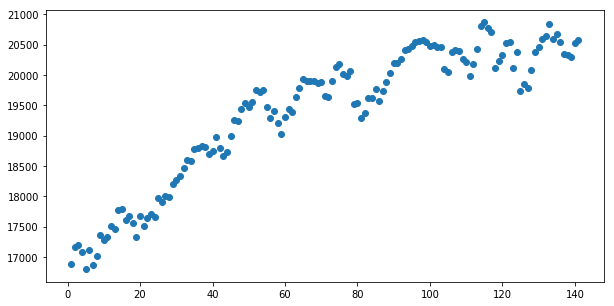

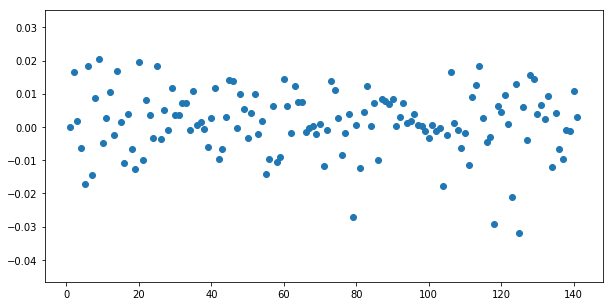

In [14]:
#まずは観察
plt.figure(figsize=(10,5))
plt.scatter(df['経過日数'],df['終値'])

plt.figure(figsize=(10,5))
plt.scatter(df['経過日数'], df['対数差収益率'])


In [15]:
from scipy.stats import shapiro

上記の分布は正規分布かどうかを見る  
見る方法として、シャピロ検定  
シャピロ関数を使う

In [16]:
shapiro(df['対数差収益率'])

(0.9684460163116455, 0.002406070474535227)

従わないことを確認できました

In [17]:
import statsmodels.api as sm

from scipy.stats import norm

from IPython.display import  display

#### 自己相関と偏自己相関

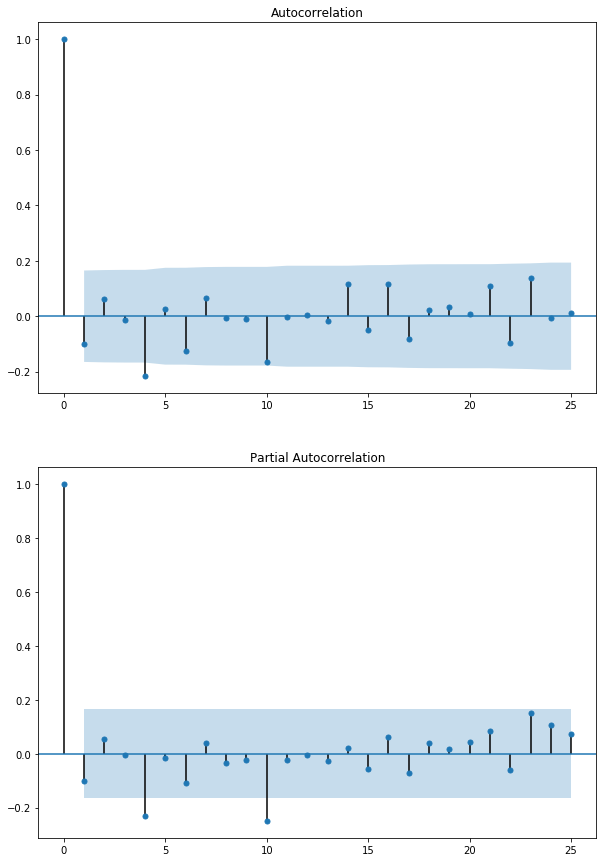

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))
#自己相関
sm.graphics.tsa.plot_acf(df['対数差収益率'].values, lags=25, ax=axes[0])
#plot_acf　これはAutocorrelation 関数
#偏自己相関
sm.graphics.tsa.plot_pacf(df['対数差収益率'].values, lags=25, ax=axes[1])
plt.show()

変自己相関なら、4個目と10個目の値は有意義水準を超えているので、  
4か10かを選べます。  

#### Step2モデルを作る
#### Step3モデルを評価して、選定

自己相関  
St = c + A1St-1 + e
eはノイズ

In [19]:
from statsmodels.tsa.ar_model import AR

ar1 = AR(df['対数差収益率'].values).fit(1)
ar4 = AR(df['対数差収益率'].values).fit(4)
ar10 = AR(df['対数差収益率'].values).fit(10)

In [20]:
print(ar1.aic)
print(ar4.aic)
print(ar10.aic)
print('AR(1) パラメタ推定値:', ar1.params) 
print('AR(4) パラメタ推定値:', ar4.params) 
print('AR(10) パラメタ推定値:', ar10.params) 

-9.27038499735326
-9.285566324183186
-9.336279822866215
AR(1) パラメタ推定値: [ 0.00155386 -0.09938513]
AR(4) パラメタ推定値: [ 0.00172793 -0.09379975  0.0783661  -0.02492801 -0.22745253]
AR(10) パラメタ推定値: [ 0.00235115 -0.05192344  0.05336912 -0.02182768 -0.24064437 -0.00287553
 -0.15957638  0.01434297 -0.02253575 -0.03995041 -0.23638162]


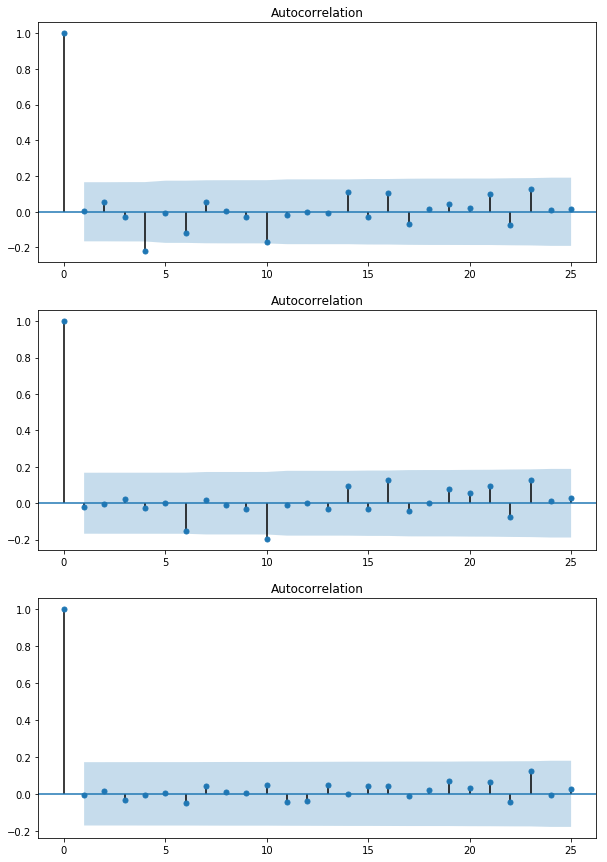

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
sm.graphics.tsa.plot_acf(ar1.resid, lags=25, ax=axes[0])
sm.graphics.tsa.plot_acf(ar4.resid, lags=25, ax=axes[1])
sm.graphics.tsa.plot_acf(ar10.resid, lags=25, ax=axes[2])
plt.show()

In [22]:
ar10.predict(start=130,end=131)

array([ 0.0069655 , -0.00289848])

In [29]:
AR(df.loc[:50, '対数差収益率'].values).fit(maxlag=10).predict(start=49, end=51)


array([0.00532799, 0.00535945, 0.00163939])

In [36]:
#残りの全期間を予測
pred_seq = np.arange(50, len(df))
preds = np.empty_like(pred_seq, dtype=float)

for i, j in enumerate(pred_seq):
    preds[i] = AR(df.loc[(j-49):j, '対数差収益率'].values).fit(maxlag=10).predict(start=49, end=51)

ValueError: setting an array element with a sequence.

日経対数差収益率のグラフ


ValueError: x and y must have same first dimension, but have shapes (92,) and (91,)

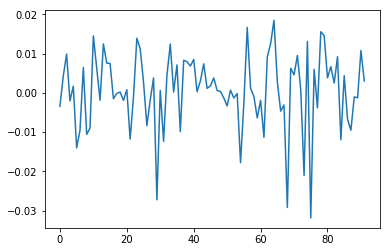

In [37]:
ans = df.loc[51:, '対数差収益率']
print('日経対数差収益率のグラフ')
plt.plot(np.arange(len(ans)), ans, label='Actual')
plt.plot(np.arange(len(ans)), preds, c='red', alpha=0.7, label='Predict')
plt.legend()
plt.show()

In [ ]:
sign_ans = np.where(ans > 0, 1, -1)
sign_preds = np.where(preds > 0, 1, -1)
prob = np.sum(sign_ans == sign_preds) / len(preds)
print('正解率:', prob)

ar1

### 中級

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import AR, ARMA, ARIMA

In [38]:
df = pd.read_csv(r'./data_practice/日経平均.csv',encoding='utf-8', engine='python')
data1 = pd.read_csv('./data_practice/austres.csv', parse_dates=['time'])
data2 = pd.read_csv('./data_practice/UKgas.csv', parse_dates=['time'])
data3 = pd.read_csv('./data_practice/EuStockMarkets.csv')
data3['time'] = np.arange(len(data3))

#### step1 確認

In [42]:
def plot_(*arg, xlab='', ylab='', title='', **kwargs):
    '''
    プロットを簡略化するための関数です
    引数
    arg: ax.plotの引数
    xlab, ylab: グラフの軸ラベル
    title: グラフタイトル
    kwargs: ax.plotのキーワード引数
    '''
    ax = plt.subplot()
    ax.plot(*arg, **kwargs)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.locator_params(nbins=5)
    plt.show()
    return None

オーストラリアの居住者の数


C:\Users\ko_kaku\Anaconda3\lib\site-packages\matplotlib\ticker.py:1449: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  str(type(self)))


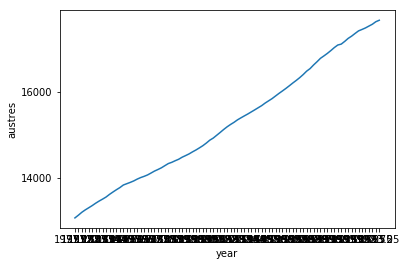

In [43]:
print('オーストラリアの居住者の数')
plot_(data1['time'], data1['austres'], xlab='year', ylab='austres')

イギリスのガス使用料金


C:\Users\ko_kaku\Anaconda3\lib\site-packages\matplotlib\ticker.py:1449: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  str(type(self)))


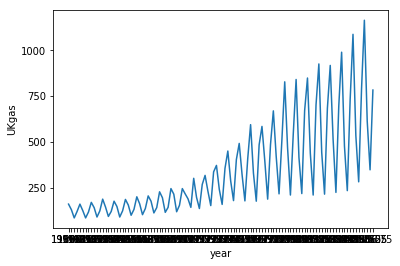

In [44]:
print('イギリスのガス使用料金')
plot_(data2['time'], data2['UKgas'], xlab='year', ylab='UKgas')

ドイツの株価指数(DAX)


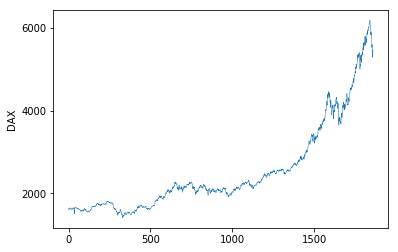

In [45]:
print('ドイツの株価指数(DAX)')
plot_(data3['time'], data3['DAX'], ylab='DAX', linewidth=0.5)